**Downloading and unzipping the dataset**

In [ ]:
!wget "https://www.dropbox.com/s/tlxserrdhe240lu/archive.zip"

--2021-09-01 14:11:59--  https://www.dropbox.com/s/tlxserrdhe240lu/archive.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/tlxserrdhe240lu/archive.zip [following]
--2021-09-01 14:11:59--  https://www.dropbox.com/s/raw/tlxserrdhe240lu/archive.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9e512c7088b6dea07b557bee42.dl.dropboxusercontent.com/cd/0/inline/BVXkPJdxvMNcZZO3tIeyySsv6ktgeFUqLWmz6hB8MNoQBcQK94_q-piFAeJ2cCMFpbP5UMnMCpUKCPRliVnyTVNy4bDnny5kFb1XcrAtdC1Dod02Eh8tvin8Um7x8frI7kcHsA5HlsdibXTfW9uP6839/file# [following]
--2021-09-01 14:12:00--  https://uc9e512c7088b6dea07b557bee42.dl.dropboxusercontent.com/cd/0/inline/BVXkPJdxvMNcZZO3tIeyySsv6ktgeFUqLWmz6hB8MNoQBcQK94_q-piFAeJ2cCMFpbP5UMnMCpUKCPRliVnyTVNy4bDnn

In [ ]:
## Unzipping the dataset
!unzip -q "/content/archive.zip"

**Preparation of the different dataset (train, validation, test)**

In [ ]:
## Importing all required libraries 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

tf.random.set_seed(4)

In [ ]:
## Creating the Pathlib Path objects
train_path = Path("chest_xray/train/")
validation_path = Path("chest_xray/test/")
test_path = Path("chest_xray/val/")

In [ ]:
## Collecting the paths inside "Normal" and "Pneumonia" of the above path
train_image_paths = train_path.glob("*/*")
val_image_paths = validation_path.glob("*/*")

## Output is a Generate Object
print(train_image_paths)

<generator object Path.glob at 0x7f961c26ded0>


In [ ]:
## Convert Generator Object in list of elements
train_image_paths = list(train_image_paths)
val_image_paths = list(val_image_paths)

## Now the output are 'PosixPath' object
print(train_image_paths[:10])

[PosixPath('chest_xray/train/NORMAL/IM-0741-0001.jpeg'), PosixPath('chest_xray/train/NORMAL/NORMAL2-IM-0551-0001.jpeg'), PosixPath('chest_xray/train/NORMAL/IM-0543-0001-0002.jpeg'), PosixPath('chest_xray/train/NORMAL/NORMAL2-IM-1142-0001-0001.jpeg'), PosixPath('chest_xray/train/NORMAL/NORMAL2-IM-0873-0001.jpeg'), PosixPath('chest_xray/train/NORMAL/IM-0631-0001.jpeg'), PosixPath('chest_xray/train/NORMAL/NORMAL2-IM-0526-0001.jpeg'), PosixPath('chest_xray/train/NORMAL/IM-0253-0001.jpeg'), PosixPath('chest_xray/train/NORMAL/IM-0668-0001.jpeg'), PosixPath('chest_xray/train/NORMAL/IM-0216-0001.jpeg')]


In [ ]:
## Convert PosixPath Objects to normal string 
train_image_paths = list(map(lambda x: str(x), train_image_paths))
val_image_paths = list(map(lambda x: str(x), val_image_paths))

print(train_image_paths[:5])

['chest_xray/train/NORMAL/IM-0741-0001.jpeg', 'chest_xray/train/NORMAL/NORMAL2-IM-0551-0001.jpeg', 'chest_xray/train/NORMAL/IM-0543-0001-0002.jpeg', 'chest_xray/train/NORMAL/NORMAL2-IM-1142-0001-0001.jpeg', 'chest_xray/train/NORMAL/NORMAL2-IM-0873-0001.jpeg']


In [ ]:
# Collect length for training and validation datasets
train_dataset_length = len(train_image_paths)
val_dataset_length = len(val_image_paths)

In [ ]:
# Every image has label in its path, so let's get it
labels = {"NORMAL":0, "PNEUMONIA":1}
inv_labels = {0:"NORMAL", 1:"PNEUMONIA"}

def get_label(path : str) -> int:
  return labels[path.split("/")[-2]]

train_labels = list(map(lambda x: get_label(x), train_image_paths))
val_labels = list(map(lambda x: get_label(x), val_image_paths))

print(train_labels[:5])

[0, 0, 0, 0, 0]


In [ ]:
batch_size = 32

## Function used for transformation 
def load_transform(image, label, train = True):
  image = tf.io.read_file(image)
  image = tf.io.decode_jpeg(image, channels = 3)
  image = tf.image.resize(image, [224, 224], method="nearest") ## 224 according to the research paper on ResNet50

  if train:
    image = tf.image.random_flip_left_right(image)

  return image, label 

In [ ]:
def get_dataset(paths, labels, train = True):
  image_paths = tf.convert_to_tensor(paths)
  labels = tf.convert_to_tensor(labels)

  image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
  label_dataset = tf.data.Dataset.from_tensor_slices(labels)

  dataset = tf.data.Dataset.zip((image_dataset, label_dataset)).shuffle(1000)

  dataset = dataset.map(lambda image, label: load_transform(image, label, train))
  dataset = dataset.repeat()
  dataset = dataset.shuffle(2000)
  dataset = dataset.batch(batch_size)

  return dataset

In [ ]:
# creating training dataset
%time train_dataset = get_dataset(train_image_paths, train_labels)

image, label = next(iter(train_dataset))

print(image.shape)
print(label.shape)

CPU times: user 147 ms, sys: 11 ms, total: 158 ms
Wall time: 194 ms
(32, 224, 224, 3)
(32,)


NORMAL


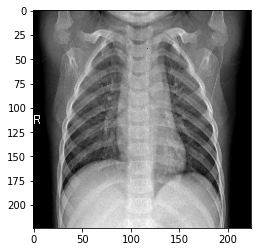

In [ ]:
## View a sample train image
print(inv_labels[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224, 224, 3))

In [ ]:
# creating validation dataset 
%time val_dataset = get_dataset(val_image_paths, val_labels, train=False)

image, label = next(iter(val_dataset))

print(image.shape)
print(label.shape)

CPU times: user 26.5 ms, sys: 1.13 ms, total: 27.7 ms
Wall time: 30.6 ms
(32, 224, 224, 3)
(32,)


PNEUMONIA


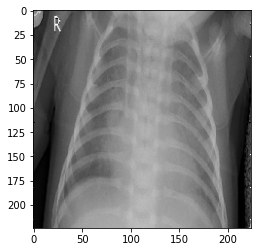

In [ ]:
## View a sample train image
print(inv_labels[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224, 224, 3))

**Modeling**

In [ ]:
# Building the CNN architecture --> ResNet50
from tensorflow.keras.applications import InceptionV3

backbone = InceptionV3(
    input_shape = (224, 224, 3),
    include_top = False,
)

model = tf.keras.Sequential([
                             backbone,
                             tf.keras.layers.GlobalAveragePooling2D(),
                             tf.keras.layers.Dense(1, activation="sigmoid")
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 21,770,401
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
## Compiling the model 
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'binary_crossentropy',
    metrics = ["accuracy", tf.keras.metrics.Precision(name ="precision"), tf.keras.metrics.Recall(name="recall")]
)

## For multiclass problem loss must be: "categorical_crossentropy"

In [ ]:
## Defining callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5", verbose=1, save_best_only=True, save_weights_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=3)

In [ ]:
val_dataset_length

624

In [ ]:
# Training the model
history = model.fit(
    train_dataset,
    steps_per_epoch = train_dataset_length//batch_size,
    epochs = 8,
    callbacks = [checkpoint, early_stop],
    validation_data = val_dataset,
    validation_steps = val_dataset_length//batch_size,
)

Epoch 1/8
163/163 [==============================] - 212s 923ms/step - loss: 0.1196 - accuracy: 0.9578 - precision: 0.9691 - recall: 0.9674 - val_loss: 0.8620 - val_accuracy: 0.8059 - val_precision: 0.9481 - val_recall: 0.7268

Epoch 00001: val_loss improved from inf to 0.86198, saving model to best_weights.h5
Epoch 2/8
163/163 [==============================] - 150s 922ms/step - loss: 0.0621 - accuracy: 0.9762 - precision: 0.9835 - recall: 0.9840 - val_loss: 0.3440 - val_accuracy: 0.8898 - val_precision: 0.9066 - val_recall: 0.9271

Epoch 00002: val_loss improved from 0.86198 to 0.34403, saving model to best_weights.h5
Epoch 3/8
163/163 [==============================] - 148s 910ms/step - loss: 0.0658 - accuracy: 0.9785 - precision: 0.9874 - recall: 0.9838 - val_loss: 0.8901 - val_accuracy: 0.7697 - val_precision: 0.7271 - val_recall: 1.0000

Epoch 00003: val_loss did not improve from 0.34403
Epoch 4/8
163/163 [==============================] - 150s 919ms/step - loss: 0.0540 - accurac

In [ ]:
history.history

{'accuracy': [0.9578220844268799,
  0.9762269854545593,
  0.9785276055335999,
  0.981019914150238,
  0.9831288456916809],
 'loss': [0.11955317109823227,
  0.06213757395744324,
  0.06575895845890045,
  0.054019540548324585,
  0.05042511969804764],
 'precision': [0.9691108465194702,
  0.9834948778152466,
  0.987364649772644,
  0.9868353009223938,
  0.9883810877799988],
 'recall': [0.9674351811408997,
  0.9840104579925537,
  0.9838129281997681,
  0.9876000881195068,
  0.9888917803764343],
 'val_accuracy': [0.8059210777282715,
  0.8898026347160339,
  0.7697368264198303,
  0.8667762875556946,
  0.75],
 'val_loss': [0.8619824647903442,
  0.34402909874916077,
  0.8901306986808777,
  0.49341002106666565,
  0.9051114916801453],
 'val_precision': [0.9480968713760376,
  0.9066339135169983,
  0.7270955443382263,
  0.9248554706573486,
  0.7226277589797974],
 'val_recall': [0.7267904281616211,
  0.927135705947876,
  1.0,
  0.8533333539962769,
  1.0]}

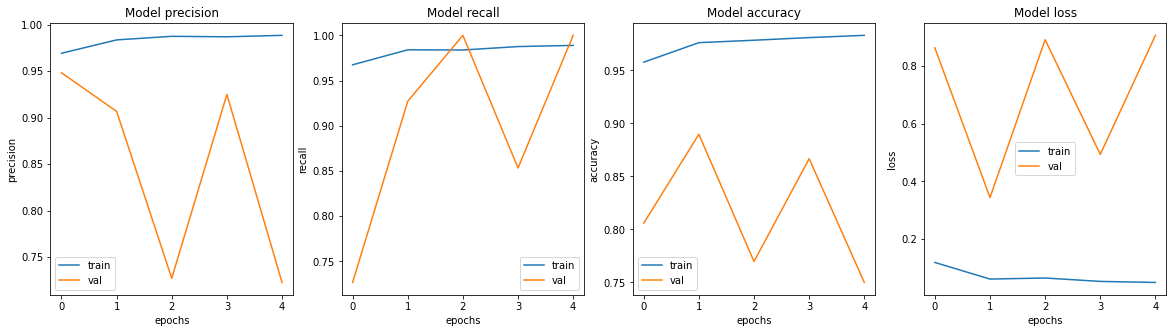

In [ ]:
# Interpreting the metrics 
fig, ax = plt.subplots(1, 4, figsize=(20,5))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "accuracy", "loss"]):
  ax[i].plot(history.history[met])
  ax[i].plot(history.history["val_" + met])
  ax[i].set_title("Model {}".format(met))
  ax[i].set_xlabel("epochs")
  ax[i].set_ylabel(met)
  ax[i].legend(["train", "val"])

**Saving and loading the model**

In [ ]:
# Saving the training model 


# loading the best weights
model.load_weights("/content/best_weights.h5")

# Saving the whole model (weights + Architecture)
model.save("model.h5")

In [ ]:
## Loading the whole model
loaded_model = tf.keras.models.load_model("/content/model.h5")

**Evaluating the model on the test data**

In [ ]:
# Create a Sataset Object for 'Testing' set 
test_image_paths = list(test_path.glob("*/*"))
test_image_paths = list(map(lambda x: str(x), test_image_paths))
test_labels = list(map(lambda x: get_label(x), test_image_paths))

test_image_paths = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image, label):
  image = tf.io.read_file(image)
  image = tf.io.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [224, 224], method='nearest')

  return image, label

test_dataset = (
    tf.data.Dataset.from_tensor_slices((test_image_paths, test_labels)).map(decode_image).batch(batch_size)
)

In [ ]:
## Verify test dataset Object
image, label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

(16, 224, 224, 3)
(16,)


NORMAL


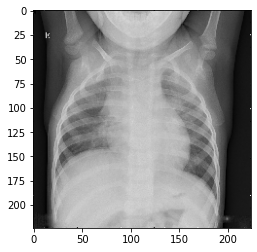

In [ ]:
## View a sample train image
print(inv_labels[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224, 224, 3))

In [ ]:
# Evaluating the loaded model
loss, acc, prec, rec = loaded_model.evaluate(test_dataset)

print("Testing accuracy :", acc)
print("Testing loss : ", loss)
print("Testing precision : ", prec)
print("Testing recall :", rec)

1/1 [==============================] - 3s 3s/step - loss: 0.1091 - accuracy: 0.9375 - precision: 1.0000 - recall: 0.8750
Testing accuracy : 0.9375
Testing loss :  0.10913122445344925
Testing precision :  1.0
Testing recall : 0.875


**Inception Network** works better on the dataset than the **ResNet Network**. Inception Network model recall is equal to 0.875 against 0.5 for the ResNet50 Network.